In [1]:
%matplotlib inline

## Functions:

In [2]:
import pandas as pd

def readTimeSeriesFromCSV(pathFileCSV, indexColumn):
    
    df = pd.read_csv(pathFileCSV, index_col = indexColumn)
    df.index.name = None
    df.reset_index(inplace = True)
    return df

In [3]:
def plotRollingMeanSTD(timeSeries, windowRange):
    
    # Determing rolling statistics
    rollingMean = timeSeries.rolling(window = windowRange, center = False).mean()
    rollingSTD = timeSeries.rolling(window = windowRange, center = False).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize = (15, 8))
    orig = plt.plot(timeSeries, color = 'blue', label = 'Original')
    mean = plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rollingSTD, color = 'black', label = 'Rolling STD')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & STD')
    #plt.show()
    return

In [4]:
from statsmodels.tsa.stattools import adfuller

def DickeyFullerTest(timeSeries):
    
    # Perform Dickey-Fuller Test:
    DFAIC = adfuller(timeSeries, autolag = 'AIC')
    DFAIC_OUT = pd.Series(DFAIC[0:4], index = ['Test Statistic:','p-value:','Lag No.:','Observation No.:'])
    for key, value in DFAIC[4].items():
        DFAIC_OUT['Critical Value (%s)'%key] = value

    print 'Results of Dickey-Fuller Test:'
    print DFAIC_OUT
    return

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposSeasonality(timeSeries, modelType = "additive"):

    # model : str{"additive", "multiplicative"}
    # The additive model:       Y[t] = T[t] + S[t] + e[t]
    # The multiplicative model: Y[t] = T[t] * S[t] * e[t]
    
    decomposition = seasonal_decompose(timeSeries, model = modelType) 
    fig = plt.figure()
    fig = decomposition.plot()  
    fig.set_size_inches(15, 8)
    #fig.show()
    return decomposition

In [6]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

def plotACFandPACF(timeSeries):
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(timeSeries, ax = ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(timeSeries, ax = ax2)
    #plt.show()
    return

In [7]:
from statsmodels.tsa.arima_model import ARIMA

pdq=[]
aic=[]

def ARIMAcalculator(ts, p, d, q):
    for pi in range(1, p+1):
        for di in range(d):
            for qi in range(1, q+1):
                model = ARIMA(ts, (pi, di, qi)).fit(disp = -1)
                aic_i = model.aic
                pdq_i = pi, di, qi
                print (pdq_i, aic_i)

                aic.append(aic_i)
                pdq.append(pdq_i)

    keys = pdq
    values = aic
    d = dict(zip(keys, values))
    print (d)

    minaic = min(d, key = d.get)

    for i in range(3):
        p = minaic[0]
        d = minaic[1]
        q = minaic[2]
        
    print (p, d, q)
    return

## Loading the Time Series Data:

In [8]:
df = readTimeSeriesFromCSV("AirPassengers.csv", "Month")
print df.iloc[:2,:]
print df.iloc[(len(df)-2):len(df),:]

     index  Passengers
0  1949-01         112
1  1949-02         118
       index  Passengers
142  1960-11         390
143  1960-12         432


In [9]:
import datetime
from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("1949-01-01", "%Y-%m-%d")

date_list = [start + relativedelta(months = x) for x in range(0, 144)]
df['index'] = date_list
df.set_index(['index'], inplace = True)
df.index.name = None

print df.iloc[:2,:]
print df.iloc[(len(df)-2):len(df),:]

            Passengers
1949-01-01         112
1949-02-01         118
            Passengers
1960-11-01         390
1960-12-01         432


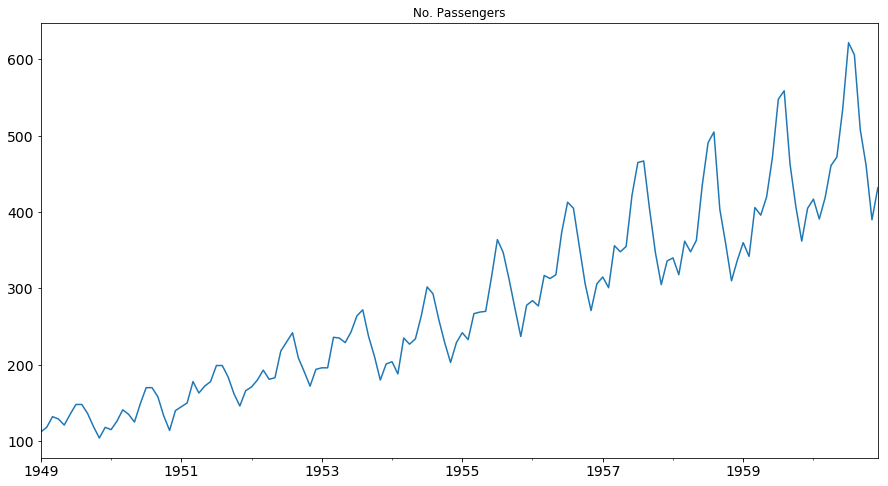

In [10]:
ts = df.Passengers
ts.plot(figsize = (15, 8), title = 'No. Passengers', fontsize = 14)

## Stationary Check:

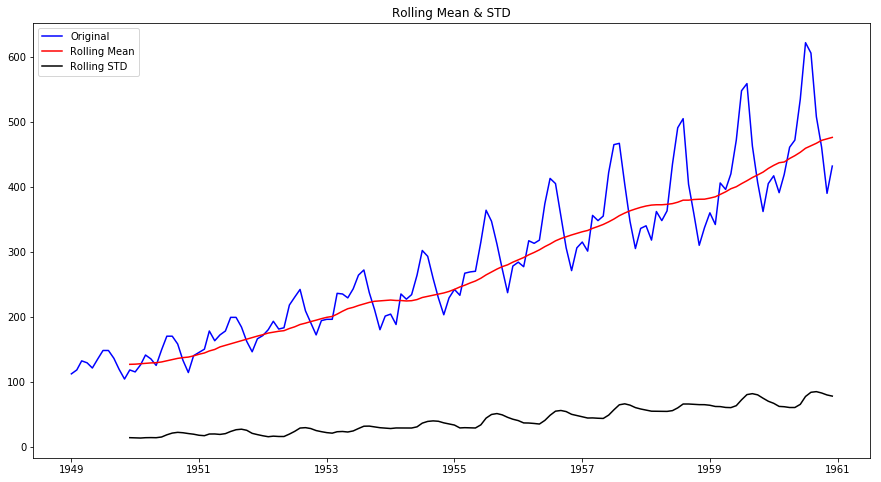

In [11]:
plotRollingMeanSTD(ts, 12)

Mean and STD curves are not constant, therefore, the stationary hypothesis is rejected.

In [12]:
DickeyFullerTest(ts)

Results of Dickey-Fuller Test:
Test Statistic:           0.815369
p-value:                  0.991880
Lag No.:                 13.000000
Observation No.:        130.000000
Critical Value (5%)      -2.884042
Critical Value (1%)      -3.481682
Critical Value (10%)     -2.578770
dtype: float64


The p-value value is high, this is another evidence which tells us that this time series is not stationary. 

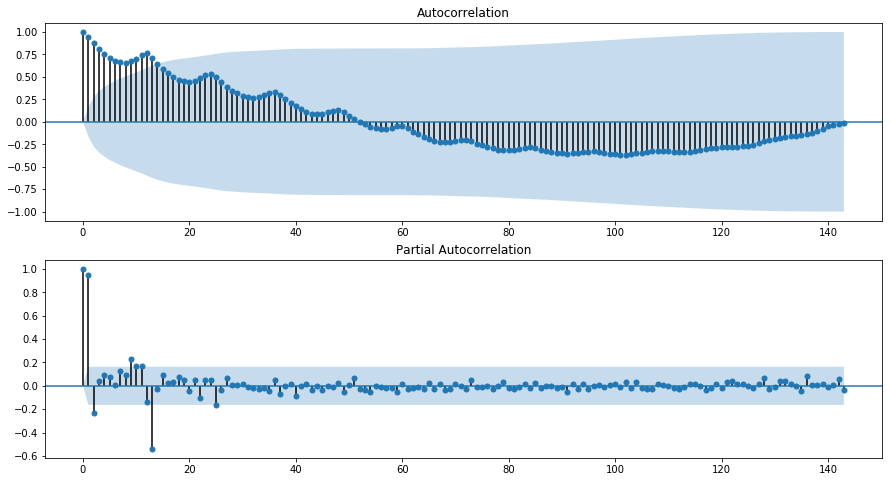

In [13]:
plotACFandPACF(ts)

There is a pattern in the Autocorrelation plot which means again this time series is not stationary.

/Users/rostam/anaconda/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


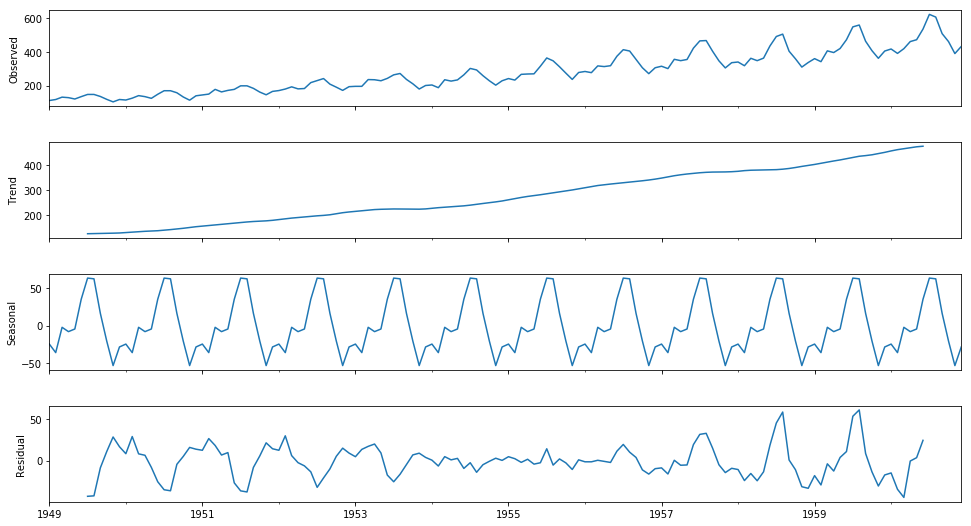

In [14]:
d1 = decomposSeasonality(ts)

In [15]:
d1_resid = d1.resid.dropna(inplace = False)
d1_trend = d1.trend.dropna(inplace = False)

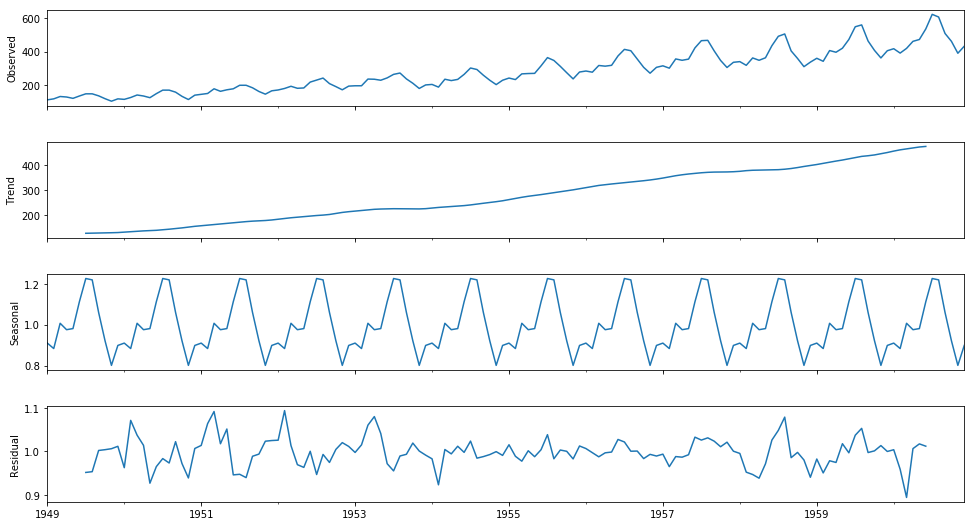

In [16]:
d2 = decomposSeasonality(ts, "multiplicative")

In [17]:
d2_resid = d2.resid.dropna(inplace = False)
d2_trend = d2.trend.dropna(inplace = False)

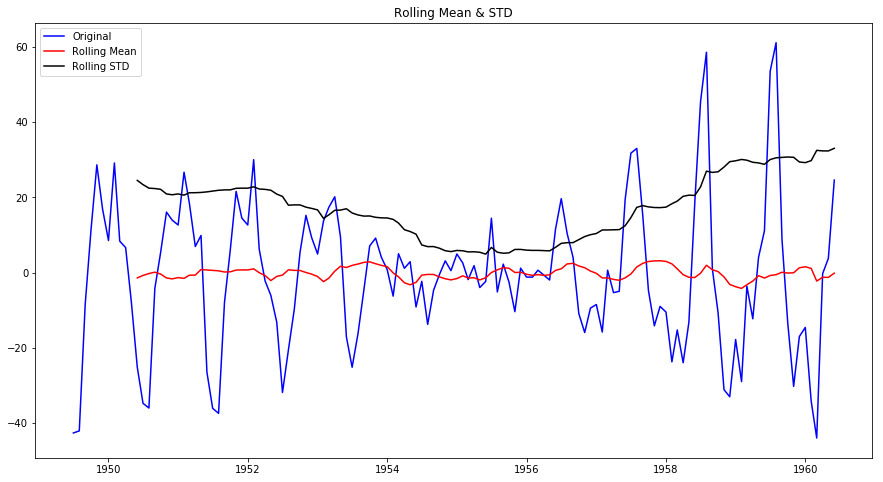

In [18]:
plotRollingMeanSTD(d1_resid, 12)

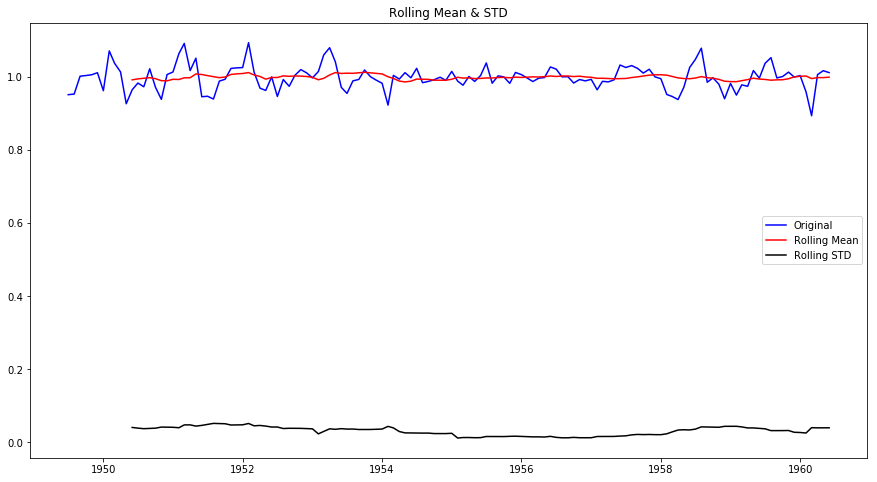

In [19]:
plotRollingMeanSTD(d2_resid, 12)

In [20]:
DickeyFullerTest(d1_resid)
print
DickeyFullerTest(d2_resid)

Results of Dickey-Fuller Test:
Test Statistic:          -5.298428
p-value:                  0.000006
Lag No.:                 13.000000
Observation No.:        118.000000
Critical Value (5%)      -2.886363
Critical Value (1%)      -3.487022
Critical Value (10%)     -2.580009
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic:        -7.415925e+00
p-value:                6.936029e-11
Lag No.:                7.000000e+00
Observation No.:        1.240000e+02
Critical Value (5%)    -2.885145e+00
Critical Value (1%)    -3.484220e+00
Critical Value (10%)   -2.579359e+00
dtype: float64


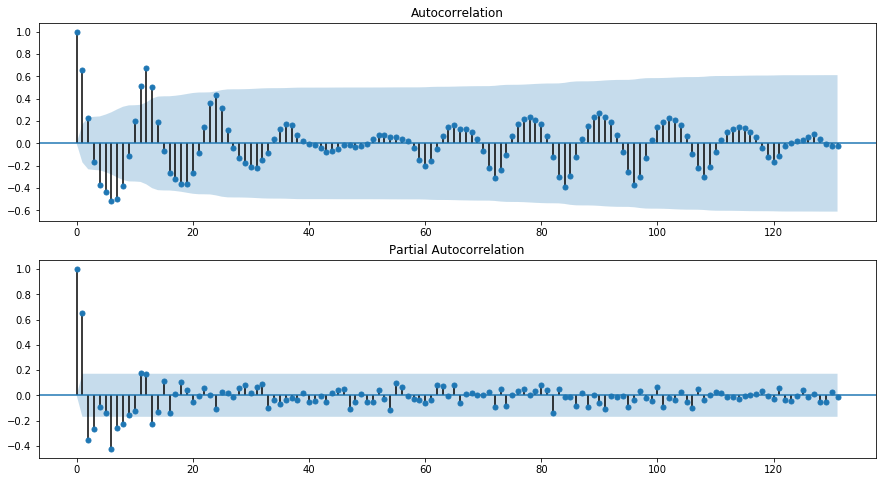

In [21]:
plotACFandPACF(d1_resid)

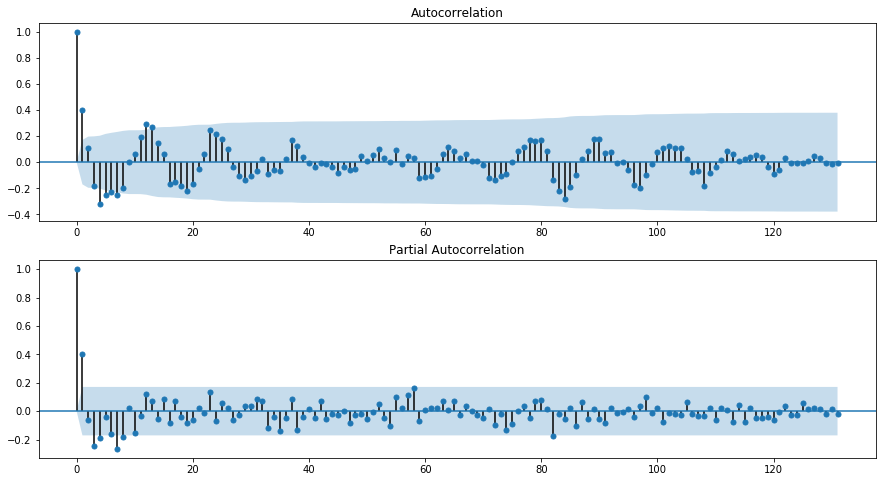

In [22]:
plotACFandPACF(d2_resid)

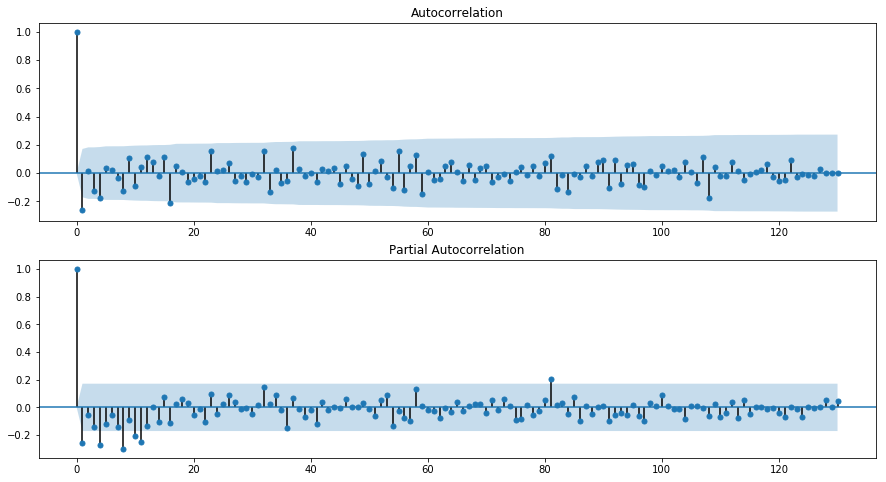

In [23]:
d2_resid_diff = (d2_resid - d2.resid.shift()).dropna(inplace = False)
plotACFandPACF(d2_resid_diff)

Differeing with shift function helped that means ARIMA(p, 1, q) are preferred to ARIMA(p, 0, q).

In [24]:
from statsmodels.tsa.arima_model import ARIMA

model_d2 = ARIMA(d2_resid, order = (5, 1, 2))
result_d2 = model_d2.fit(disp = -1)
print result_d2.summary()

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  131
Model:                 ARIMA(5, 1, 2)   Log Likelihood                 277.214
Method:                       css-mle   S.D. of innovations              0.029
Date:                Mon, 20 Mar 2017   AIC                           -536.428
Time:                        21:57:25   BIC                           -510.552
Sample:                    08-01-1949   HQIC                          -525.913
                         - 06-01-1960                                         
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const              -2.719e-05   7.33e-05     -0.371      0.711        -0.000     0.000
ar.L1.D.Passengers    -0.5582      0.110     -5.081      0.000        -0.774    -0.343
ar.L2.D.Passengers  

/Users/rostam/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


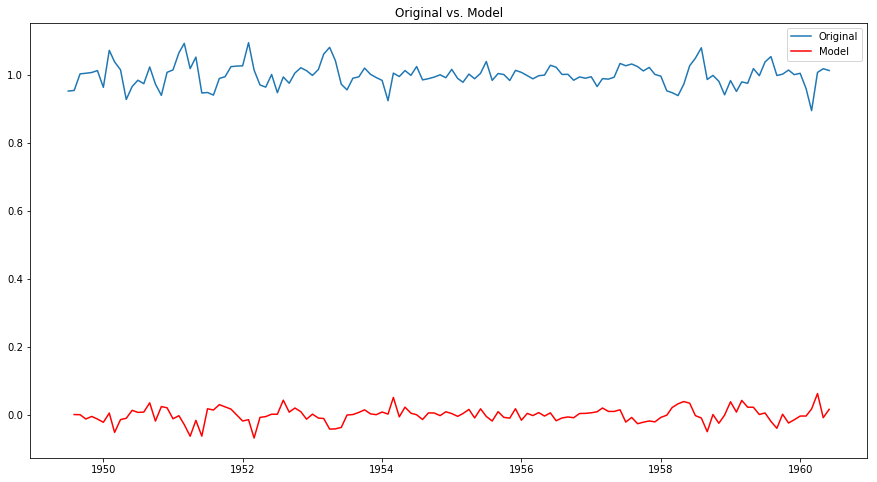

In [25]:
fig = plt.figure(figsize = (15, 8))
plt.plot(d2_resid, label = 'Original')
plt.plot(result_d2.fittedvalues, color = 'red', label = 'Model')
plt.legend(loc = 'best')
plt.title('Original vs. Model')
plt.show()

## Procedure to find Prediction Trend:

In [26]:
print d2_trend.index[0]
print d2_trend.index[len(d2_trend) - 1]

1949-07-01 00:00:00
1960-06-01 00:00:00


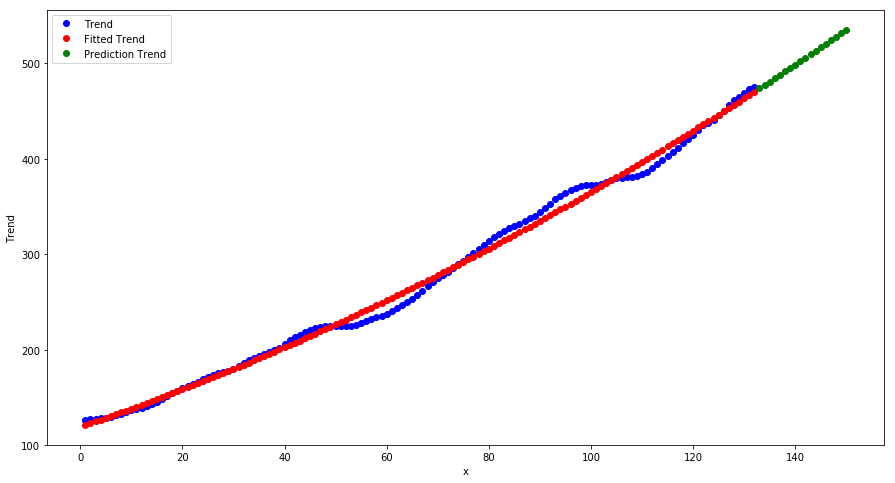

In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a*x*x+x + b*x+x + c*x + d

y = d2_trend.values
x = np.linspace(1, len(y), len(y))

n_p = 18
len_ys = len(y) + n_p

xs = np.linspace(1, len_ys, len_ys)

popt, pcov = curve_fit(func, x, y)

xp = np.linspace(len(y)+1, len_ys, n_p)

fig = plt.figure(figsize = (15, 8))
plt.plot(x, y, 'bo', label = 'Trend')
plt.plot(x, func(x, *popt), 'ro', label = 'Fitted Trend')
yp = func(xp, *popt)
plt.plot(xp, yp, 'go', label='Prediction Trend')

plt.xlabel('x')
plt.ylabel('Trend')
plt.legend(loc = 'best')
plt.show()

In [28]:
start = datetime.datetime.strptime("1949-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months = x) for x in range(0, 150)]
d2_trend_predict = pd.Series(np.array(y.tolist() + yp.tolist()), index = pd.DatetimeIndex(date_list))
d2_trend_predict.name = "Passengers"

## Calculating the Residual Prediction:

In [29]:
d2_resid_perdict = result_d2.predict(start = '1949-08-01', end = '1961-06-01')
d2_resid_perdict.name = "Passengers"

/Users/rostam/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


## Calculating the Seasonal Prediction:

In [30]:
start = datetime.datetime.strptime("1961-01-01", "%Y-%m-%d")
date_tmp = [start + relativedelta(months = x) for x in range(0, 12)]

seasonLength = len(d2.seasonal)
values_tmp = list(d2.seasonal.values[(seasonLength-12):seasonLength])

d2_seasonal_tmp = pd.Series(np.array(values_tmp), index = pd.DatetimeIndex(date_tmp))
d2_seasonal_tmp.name = "Passengers"
d2_seasonal = d2.seasonal
d2_seasonal_predict = d2_seasonal.append(d2_seasonal_tmp)

## Plot the Time Series Forecast:

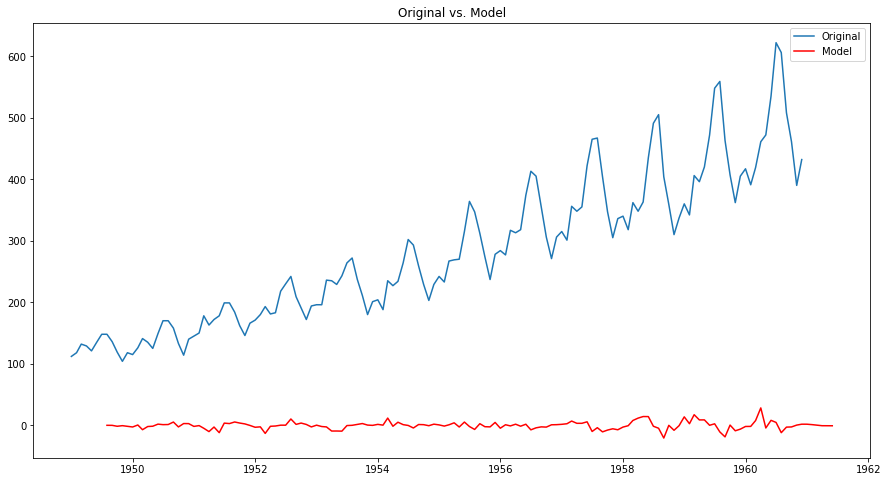

In [31]:
fig = plt.figure(figsize = (15, 8))
plt.plot(ts, label = 'Original')
d2_predict = d2_trend_predict * d2_seasonal_predict * d2_resid_perdict
plt.plot(d2_predict, color = 'red', label = 'Model')
plt.legend(loc = 'best')
plt.title('Original vs. Model')
plt.show()